In [1]:
import os
from os import path, getcwd, listdir, mkdir

import sys
sys.path.insert(0, '../../fhn_model/')

import torch as t
from torch.distributions import uniform
import numpy as np
import pandas as pd

from tqdm import tqdm
import matplotlib.pyplot as plt

from experiment_helper import chop_and_shuffle_data, generate_sequence, dataset_dist
from diffusion_gumbel import diffuse_STE
from reaction_diff import  rho_STE

In [2]:
device = t.device('cuda' if t.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


generate dataset

In [32]:
if not "data" in listdir(getcwd()):
    mkdir(path.join(getcwd(), "data"))

grid = t.zeros((2, 32, 32), device=device)
grid[:] = 25
grid[0, 13:18] = 40

gamma = 0.008
k1 = k1_bar = 0.98
k2 = k2_bar = 0.1
k3 = k3_bar = 0.2

N = 50
num_steps = 10_000
DA = 0.1
DB = 0.4

generate_sequence(
    grid,
    num_steps,
    N,
    use_diffusion=True,
    DA=DA,
    DB=DB,
    use_reaction=True,
    gamma=gamma,
    k1=k1,
    k1_bar=k1_bar,
    k2=k2,
    k2_bar=k2_bar,
    k3=k3,
    k3_bar=k3_bar,
    create_vis=False,
    save_steps=True,
    create_seq=False,
)

  0%|          | 0/10000 [00:00<?, ?it/s]

c:\Users\jsche\anaconda3\envs\torchenv\lib\site-packages\torch\distributions\distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)
100%|██████████| 10000/10000 [01:22<00:00, 121.67it/s]


In [33]:
data_dir = path.join(getcwd(), "data")
experiment_dir = path.join(data_dir, listdir(data_dir)[-1])
ref_state = t.load(path.join(experiment_dir, "batch_100", "0.pt"), map_location=device)
ref_state = ref_state.unsqueeze(0)

torch.Size([1, 2, 32, 32])


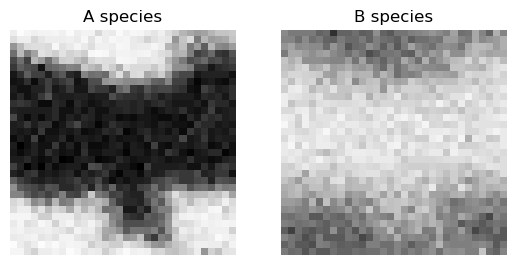

In [39]:
print(ref_state.shape)
fig, axs = plt.subplots(1,2)
axs[0].imshow(ref_state[0,0].cpu(),cmap="Greys",interpolation="nearest",vmin=0,vmax=50)
axs[0].set_title("A species")
axs[0].axis("off")
axs[1].imshow(ref_state[0,1].cpu(),cmap="Greys",interpolation="nearest",vmin=0,vmax=50)
axs[1].set_title("B species")
axs[1].axis("off")
plt.show()

In [36]:
def loss_fn(X, Y):
    return t.log(t.sum((X[:, 0] - Y[:,0])**2 + (X[:, 1] - Y[:,1])**2, dim=(0,1,2)))

In [41]:
# define a sequence of DA values to test
DA_vals = t.linspace(0., 1., 11, device=device)
# define a sequence of DB values to test
DB_vals = t.linspace(0., 1., 11, device=device)
grid_DA, grid_DB = t.meshgrid(DA_vals, DB_vals, indexing="ij")

# rate coefficients
k1 = t.tensor(0.98, device=device)
k1_bar = t.tensor(0.98, device=device)
k2 = t.tensor(0.1, device=device)
k2_bar = t.tensor(0.1, device=device)
k3 = t.tensor(0.2, device=device)
k3_bar = t.tensor(0.2, device=device)
# reaction time constant
gamma = t.tensor(0.008, device=device)
N = 50


# collect the results of each test run here
grads_DA = []
grads_DB = []
distances = []
# iterate over the DB values
for DA_idx in range(grid_DA.shape[0]):
    # iterate over the DA values
    for DB_idx in tqdm(range(grid_DB.shape[0])):
        X = t.zeros((1, 2, 32, 32), device=device)
        X[:] = 25
        X[0, 13:18] = 40
        
        DA = grid_DA[DA_idx, DB_idx]
        DA.requires_grad_()
        DB = grid_DB[DA_idx, DB_idx]
        DB.requires_grad_()
        for i in range(10_000):
            # 1. run the diffusion step on each sample
            X = diffuse_STE(X, N, DA, DB)
            # 2. run the reaction step on each sample
            X = rho_STE(X, N, gamma, k1, k1_bar, k2, k2_bar, k3, k3_bar)
        # use the sum of dim-specific distances
        dist_val = loss_fn(X, ref_state)
        distances.append(dist_val.detach().cpu().numpy())
        # find the gradient of the distance w.r.t. the diffusion coefficients
        grad_DA, grad_DB = t.autograd.grad(dist_val, (DA, DB))
        grads_DA.append(grad_DA.detach().cpu().numpy())
        grads_DB.append(grad_DB.detach().cpu().numpy())

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [26:51<00:00, 146.48s/it]


<Figure size 640x480 with 0 Axes>

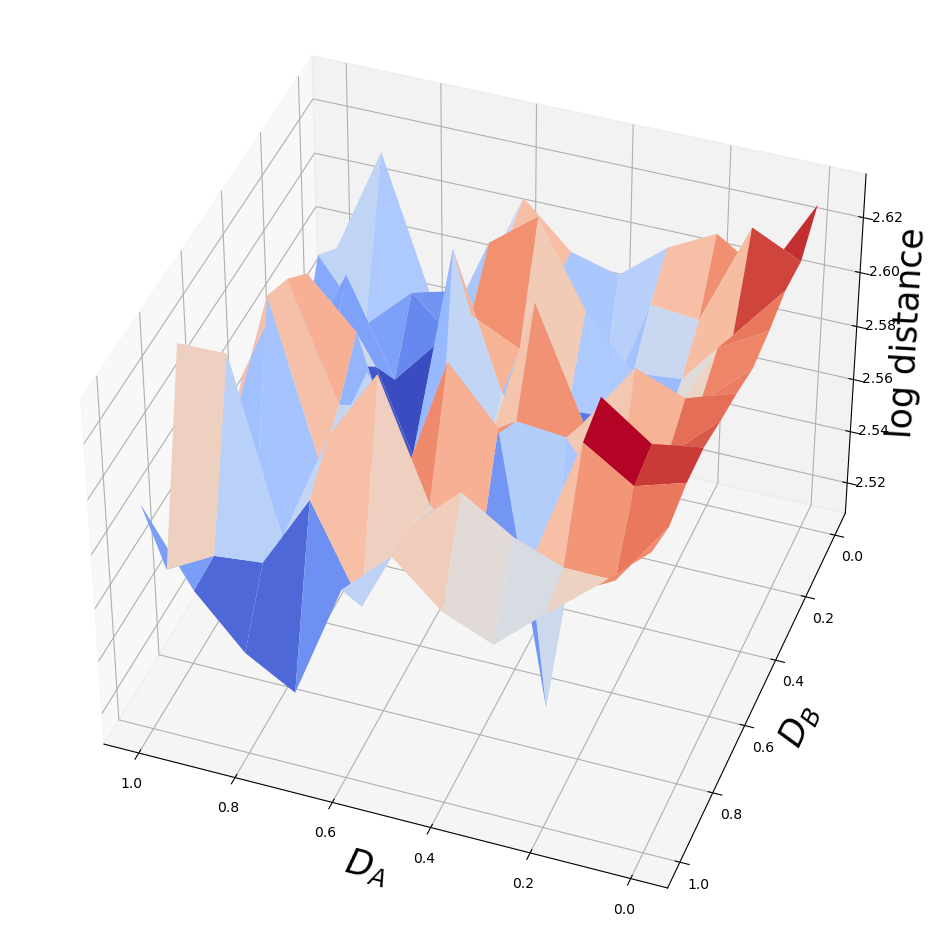

<Figure size 640x480 with 0 Axes>

In [45]:
from matplotlib import cm
from matplotlib import rcParams

fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(12,12))
ax.set(ylabel="D_B") 
ax.set_xlabel('$D_A$', fontsize=25)
ax.set_ylabel('$D_B$', fontsize=25)
ax.set_zlabel('log distance', fontsize=25, rotation = 0, position=(10,10))
ax.plot_surface(grid_DA.cpu(), grid_DB.cpu(), np.log(np.array(distances)).reshape(11,11), cmap=cm.coolwarm, alpha=1)

ax.view_init(40, 110)

plt.figure(constrained_layout=True)

In [ ]:
from torch.distributions import uniform
param_sampler = uniform.Uniform(0,1)

DA = param_sampler.sample().to(device)
DB = param_sampler.sample().to(device)

In [ ]:
gamma = 0.005
N = 50
k1 = t.tensor(0.98, device=device)
k2 = t.tensor(0.1, device=device)
k3 = t.tensor(0.2, device=device)

if ref_state.ndim == 3:
    ref_state = ref_state.unsqueeze(0)

DA_vals = [DA.detach().cpu().numpy()]
DB_vals = [DB.detach().cpu().numpy()]
losses = []
grads_DA = []
grads_DB = []

In [ ]:
for i in tqdm(range(5_000)):
    X = ref_state.detach().clone()
    
    DA.requires_grad_()
    DB.requires_grad_()
    
    # Make predictions for this batch
    for sim_step in range(500):
        # run the diffusion step
        X = diffuse_STE(X, N, DA, DB)
        # run the reaction step
        X = rho_STE(X, N, gamma, k1, k1, k2, k2, k3, k3)
        
    # Compute the loss and its gradients
    loss = loss_fn(ref_state, X)
    grad_DA, grad_DB = t.autograd.grad(loss, (DA, DB))

    DA = DA - 0.01 * grad_DA
    DB = DB - 0.01 * grad_DB
            
    with t.no_grad():
        k1 = k1.clamp(0, 1)
        k2 = k2.clamp(0, 1)
        k3 = k3.clamp(0, 1)
        DB = DB.clamp(0, 1)
    
    DA_vals.append(DA.detach.cpu().numpy())
    DB_vals.append(DB.detach().cpu().numpy())
    losses.append(loss.detach().cpu().numpy())
    grads_DA.append(grad_DA.detach().cpu().numpy())
    grads_DB.append(grad_DB.detach().cpu().numpy())